## Bivariate Mixed Outcome Model: Poisson and Bernoulli VC Run-time and MSE Results 

In this example, $y_{i1} \sim Poisson(\mu_{i1}(\mathbf{\beta_1}))$ and $y_{i2} \sim Bernoulli(\mu_{i2}(\mathbf{\beta_2}))$

We have three fixed effects for each outcome, $\beta_{true} \sim rand(Uniform(-0.2, 0.2), p)$ where p = 6 fixed effects stacking $\beta_1, \beta_2$

In this example we have Poisson and Bernoulli base distribution with Log and Logit Link functions and covariance matrix $\Gamma$ structured under VC covariance with $\theta = 0.5$, we want to compare the MSE with that of GLM.

We use multi-threading on 8 threads to obtain these MSE results on the following machine, and include MSE results from 100 simulation runs comparing the fit of ours with that of the individual GLM's from GLM.jl for each scenario.

In [1]:
versioninfo()

Julia Version 1.6.2
Commit 1b93d53fc4 (2021-07-14 15:36 UTC)
Platform Info:
  OS: macOS (x86_64-apple-darwin18.7.0)
  CPU: Intel(R) Core(TM) i9-9880H CPU @ 2.30GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-11.0.1 (ORCJIT, skylake)


In [2]:
using QuasiCopula, DelimitedFiles, LinearAlgebra, Random, GLM
using DataFrames

In [3]:
p = 6    # number of fixed effects, including intercept
m = 1    # number of variance components
# true parameter values
Random.seed!(12345)
βtrue = rand(Uniform(-0.2, 0.2), p)
θtrue = [0.5]

# generate data
intervals = zeros(p + m, 2) #hold intervals
curcoverage = zeros(p + m) #hold current coverage resutls
trueparams = [βtrue; θtrue] #hold true parameters

#simulation parameters
samplesizes = [100; 1000; 10000]
ns = [2]
nsims = 100;

In [4]:
@info "reading in the files with results"
βMseresult = vec(readdlm("mse_beta_bivariate_mixed_poisson_bernoulli_vcm$(nsims)reps_sim.csv", ','))
θMseresult = vec(readdlm("mse_theta_bivariate_mixed_poisson_bernoulli_vcm$(nsims)reps_sim.csv", ','))
fittimes_QC = vec(readdlm("fittimes_bivariate_mixed_poisson_bernoulli_vcm$(nsims)reps_sim.csv", ','))

┌ Info: reading in the files with results
└ @ Main In[4]:1


300-element Vector{Float64}:
 0.055876569
 0.05169188
 0.04627482
 0.05379078
 0.078683314
 0.096188252
 0.053742771
 0.049967661
 0.065788149
 0.060227587
 0.058518731
 0.062123602
 0.058123443
 ⋮
 0.278076082
 0.29130668
 0.277178551
 0.274608972
 0.280352375
 0.285157007
 0.336329178
 0.271592152
 0.26719782
 0.279885771
 0.250855866
 0.224416344

In [5]:
fittimes_GLM = vec(readdlm("fittimes_GLM_bivariate_mixed_poisson_bernoulli_vcm$(nsims)reps_sim.csv", ','))

300-element Vector{Float64}:
 0.000394728
 0.000320609
 0.00026606
 0.000257867
 0.000259093
 0.000259492
 0.000258773
 0.000345545
 0.000265853
 0.000428184
 0.000258939
 0.000304074
 0.000258303
 ⋮
 0.007455069
 0.009677522
 0.00909441
 0.007481214
 0.007572443
 0.007482175
 0.007127618
 0.007502544
 0.007516704
 0.007493371
 0.0073635
 0.010219129

In [6]:
#simulation parameters
@info "making results table Quasi-Copula"
sample_sizes = repeat(string.(samplesizes), inner = nsims * length(ns))
obs_sizes = repeat(string.(ns), inner = nsims, outer = length(samplesizes))

msedf = DataFrame(samplesize = sample_sizes, obssize = obs_sizes, fittimes = fittimes_QC)
timedf1 = combine(groupby(msedf, [:samplesize, :obssize]), :fittimes => mean => :fittime,
    :fittimes => x -> (std(x)/sqrt(length(x))))
rename!(timedf1, Dict(:fittimes_function => "se"))
timedf1[!, :nobs] = Meta.parse.(timedf1[!, :samplesize]) .* Meta.parse.(timedf1[!, :obssize])
timedf1[!, :fitmin] = timedf1[!, :fittime] - timedf1[!, :se]
timedf1[!, :fitmax] = timedf1[!, :fittime] + 2 * timedf1[!, :se]
timedf1[!, :perobsratio] = timedf1[!, :fittime] ./ timedf1[!, :nobs]
timedf1

┌ Info: making results table Quasi-Copula
└ @ Main In[6]:2


,samplesize,obssize,fittime,se,nobs,fitmin,fitmax,perobsratio
,String,String,Float64,Float64,Int64,Float64,Float64,Float64
1,100,2,0.0574067,0.00143534,200,0.0559713,0.0602774,0.000287033
2,1000,2,0.0724846,0.00190744,2000,0.0705772,0.0762995,3.62423e-5
3,10000,2,0.29015,0.0044937,20000,0.285657,0.299138,1.45075e-5


In [7]:
#simulation parameters
@info "making results table GLMM"
sample_sizes = repeat(string.(samplesizes), inner = nsims * length(ns))
obs_sizes = repeat(string.(ns), inner = nsims, outer = length(samplesizes))

msedf = DataFrame(samplesize = sample_sizes, obssize = obs_sizes, fittimes = fittimes_GLM)
timedf2 = combine(groupby(msedf, [:samplesize, :obssize]), :fittimes => mean => :fittime,
    :fittimes => x -> (std(x)/sqrt(length(x))))
rename!(timedf2, Dict(:fittimes_function => "se"))
timedf2[!, :nobs] = Meta.parse.(timedf2[!, :samplesize]) .* Meta.parse.(timedf2[!, :obssize])
timedf2[!, :fitmin] = timedf2[!, :fittime] - timedf2[!, :se]
timedf2[!, :fitmax] = timedf2[!, :fittime] + timedf2[!, :se]
timedf2[!, :perobsratio] = timedf2[!, :fittime] ./ timedf2[!, :nobs]
timedf2

┌ Info: making results table GLMM
└ @ Main In[7]:2


,samplesize,obssize,fittime,se,nobs,fitmin,fitmax,perobsratio
,String,String,Float64,Float64,Int64,Float64,Float64,Float64
1,100,2,0.000270659,3.24715e-6,200,0.000267412,0.000273907,1.3533e-6
2,1000,2,0.0103499,0.00965058,2000,0.000699323,0.0200005,5.17495e-6
3,10000,2,0.0110279,0.00203968,20000,0.00898823,0.0130676,5.51396e-7


In [8]:
######  supplementary table s1
using Random, DataFrames, DelimitedFiles, Statistics
import StatsBase: sem

βθcoverage = readdlm("beta_theta_coverage_bivariate_mixed_poisson_bernoulli_vcm$(nsims)reps_sim.csv", ',')

m  = 1

covdf = DataFrame(Matrix(transpose(βθcoverage)), :auto)
rename!(covdf, Symbol.([["β$i" for i in 1:p]; ["θ$i" for i in 1:m]]))
covdf[!, :samplesize] = sample_sizes
covdf[!, :obssize] = obs_sizes
first(covdf, 10)

row_stats = [[(mean(col), sem(col)) for col = eachcol(d[!, 1:end-2])] for d = groupby(covdf, [:samplesize; :obssize])]
df = DataFrame(row_stats, :auto)
ss_obs = unique("N: " .* sample_sizes .* "  ni: " .* obs_sizes)
rename!(df, Symbol.(ss_obs))
covdfdisplay = DataFrame([[names(df)]; collect.(eachrow(df))], 
    [:people_obs; Symbol.([["β$i" for i in 1:p]; ["θ$i" for i in 1:m]])])
# deletecols!(covdfdisplay, p + 2)
covdfdisplay


,people_obs,β1,β2,β3,β4
,String,Tuple…,Tuple…,Tuple…,Tuple…
1,N: 100 ni: 2,"(0.66, 0.0476095)","(0.76, 0.0429235)","(0.73, 0.0446196)","(0.58, 0.0496045)"
2,N: 1000 ni: 2,"(0.69, 0.0464823)","(0.71, 0.0456048)","(0.63, 0.0485237)","(0.6, 0.0492366)"
3,N: 10000 ni: 2,"(0.76, 0.0429235)","(0.72, 0.0451261)","(0.71, 0.0456048)","(0.6, 0.0492366)"


In [9]:
βθcoverage_GLM = readdlm("beta_theta_coverage_GLM_bivariate_mixed_poisson_bernoulli_vcm$(nsims)reps_sim.csv", ',')

m = 1

covdf = DataFrame(Matrix(transpose(βθcoverage_GLM)), :auto)
rename!(covdf, Symbol.([["β$i" for i in 1:p]; ["θ$i" for i in 1:m]]))
covdf[!, :samplesize] = sample_sizes
covdf[!, :obssize] = obs_sizes
first(covdf, 10)

row_stats = [[(mean(col), sem(col)) for col = eachcol(d[!, 1:end-2])] for d = groupby(covdf, [:samplesize; :obssize])]
df = DataFrame(row_stats, :auto)
ss_obs = unique("N: " .* sample_sizes .* "  ni: " .* obs_sizes)
rename!(df, Symbol.(ss_obs))
covdfdisplay = DataFrame([[names(df)]; collect.(eachrow(df))], 
    [:people_obs; Symbol.([["β$i" for i in 1:p]; ["θ$i" for i in 1:m]])])
# deletecols!(covdfdisplay, p + 2)
covdfdisplay


,people_obs,β1,β2,β3,β4
,String,Tuple…,Tuple…,Tuple…,Tuple…
1,N: 100 ni: 2,"(0.64, 0.0482418)","(0.95, 0.0219043)","(0.93, 0.0256432)","(0.93, 0.0256432)"
2,N: 1000 ni: 2,"(0.01, 0.01)","(0.91, 0.0287623)","(0.91, 0.0287623)","(0.92, 0.027266)"
3,N: 10000 ni: 2,"(0.0, 0.0)","(0.46, 0.0500908)","(0.88, 0.0326599)","(0.68, 0.0468826)"


In [10]:
#### 
#import data and reorganize to create figure
using Random, DataFrames, DelimitedFiles, Statistics, RCall, Printf
import StatsBase: sem

βMseresult = vec(readdlm("mse_beta_bivariate_mixed_poisson_bernoulli_vcm$(nsims)reps_sim.csv", ','))
θMseresult = vec(readdlm("mse_theta_bivariate_mixed_poisson_bernoulli_vcm$(nsims)reps_sim.csv", ','))

βMseresult_GLM = vec(readdlm("mse_beta_GLM_bivariate_mixed_poisson_bernoulli_vcm$(nsims)reps_sim.csv", ','))
θMseresult_GLM = vec(readdlm("mse_theta_GLM_bivariate_mixed_poisson_bernoulli_vcm$(nsims)reps_sim.csv", ','))

p = 6; m = 1
sample_sizes = repeat(string.(samplesizes), inner = nsims * length(ns))
obs_sizes = repeat(string.(ns), inner = nsims, outer = length(samplesizes))
msedf1 = DataFrame(βmse = βMseresult, thetamse = θMseresult, 
    samplesize = sample_sizes, obssize = obs_sizes)

msedf2 = DataFrame(βmse = βMseresult_GLM, thetamse = θMseresult_GLM, 
    samplesize = sample_sizes, obssize = obs_sizes)

#rename to make parsing easier for R.

msedf1 = deepcopy(msedf1)
rename!(msedf1, ["betamse"
    "thetamse"
    "samplesize"
 "obssize"]);

msedf2 = deepcopy(msedf2)
rename!(msedf2, ["betamse"
    "thetamse"
    "samplesize"
 "obssize"]);

mses = [msedf1[!, :betamse]; msedf1[!, :thetamse]; msedf2[!, :betamse]; msedf2[!, :thetamse]]
    # msedfnormR[!, :betamse]; msedfnormR[!, :taumse]; msedfnormR[!, :Sigmamse]]
obssize = [collect([repeat(msedf1[!, :obssize], 2)]...) ; collect([repeat(msedf2[!, :obssize], 2)]...)]
#40
samplesize = [collect([repeat(msedf1[!, :samplesize], 2)]...) ; collect([repeat(msedf2[!, :samplesize], 2)]...)]

parameters = [collect([repeat(string.([:beta, :theta]), inner = nsims * length(ns) * length(samplesizes))]...) ; collect([repeat(string.([:beta, :theta]), inner = nsims * length(ns) * length(samplesizes))]...)]
robust = [collect([repeat(["Bivariate Mixed Poisson Bernoulli QC"], 2 * nsims * length(ns) * length(samplesizes))]...); collect([repeat(["Separate Poisson Bernoulli GLM"],  2 * nsims * length(ns) * length(samplesizes))]...)]

msedfR = DataFrame(mse = mses, obssize = obssize, samplesize = samplesize,
    parameters = parameters, robust = robust)

#5 of the 30,000 simulations did not converge, filter out
msedfR = filter(x -> !isnan(x.mse), msedfR)
# additionally, there are 5 where an error was not caught so it did not try a differnt solver
msedfR = filter(x -> x.mse < 40000, msedfR)

,mse,obssize,samplesize,parameters,robust
,Float64,String,String,String,String
1,0.0119292,2,100,beta,Bivariate Mixed Poisson Bernoulli QC
2,0.0221496,2,100,beta,Bivariate Mixed Poisson Bernoulli QC
3,0.0398217,2,100,beta,Bivariate Mixed Poisson Bernoulli QC
4,0.0487533,2,100,beta,Bivariate Mixed Poisson Bernoulli QC
5,0.0324409,2,100,beta,Bivariate Mixed Poisson Bernoulli QC
6,0.932151,2,100,beta,Bivariate Mixed Poisson Bernoulli QC
7,0.102978,2,100,beta,Bivariate Mixed Poisson Bernoulli QC
8,0.0758113,2,100,beta,Bivariate Mixed Poisson Bernoulli QC
9,0.148822,2,100,beta,Bivariate Mixed Poisson Bernoulli QC


┌ Warning: RCall.jl: Warning: package ‘scales’ was built under R version 4.0.2
└ @ RCall /Users/sarahji/.julia/packages/RCall/6kphM/src/io.jl:172
┌ Warning: RCall.jl: Warning: package ‘ggplot2’ was built under R version 4.0.2
└ @ RCall /Users/sarahji/.julia/packages/RCall/6kphM/src/io.jl:172
┌ Warning: RCall.jl: Warning: package ‘data.table’ was built under R version 4.0.2
└ @ RCall /Users/sarahji/.julia/packages/RCall/6kphM/src/io.jl:172


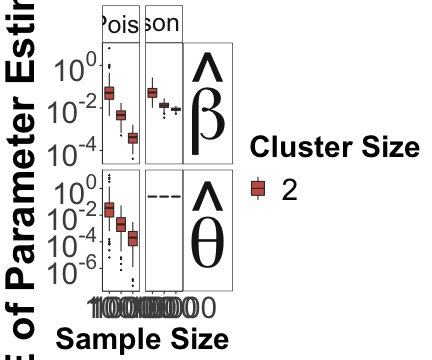

RObject{VecSxp}


In [11]:
### working on figure next
@rput msedfR

R"""
library(scales)
library(ggplot2)
library(data.table)

msedfR = data.table(msedfR)

msedfR[parameters == "beta",y_min := 10^-4]
msedfR[parameters == "beta",y_max := 10^-2]
msedfR[parameters == "theta",y_min := 10^-5]
msedfR[parameters == "theta",y_max := 10^1]

#msedfR[parameters == "beta",y_min := 10^-8]
#msedfR[parameters == "beta",y_max := 10^-2]
#msedfR[parameters == "tau",y_min := 10^-8]
#msedfR[parameters == "tau",y_max := 10^-2]
#msedfR[parameters == "Sigma",y_min := 10^-5]
#msedfR[parameters == "Sigma",y_max := 10^-2]


msedfR$obssize = factor(msedfR$obssize, levels = c('2', '5', '10', '15', '20', '25'))
msedfR$samplesize = factor(msedfR$samplesize, levels = c('100', '1000', '10000'))
msedfR$parameters = factor(msedfR$parameters, levels = c('beta', 'theta'), labels = c(beta = expression(hat(bold(beta))), thetaa = expression(hat(bold(theta))[])))
msedfR$robust <- factor(msedfR$robust, levels = c('Bivariate Mixed Poisson Bernoulli QC', 'Separate Poisson Bernoulli GLM'),
    labels = c(expression(paste("Bivariate Mixed Poisson Bernoulli QC")), expression(paste("Separate Poisson Bernoulli GLM"))))


#mseplot <- ggplot(msedfR[msedfR$mse < 10^0, ], aes(x=samplesize, y=mse, fill=obssize)) + 
mseplot = ggplot(msedfR[msedfR$mse < 10^3, ], aes(x=samplesize, y=mse, fill=obssize)) + 
  #geom_boxplot(outlier.size = 0.0, outlier.alpha = 0) +
  geom_boxplot(outlier.size = 0.25) +
#    geom_violin() +
    facet_grid(parameters ~ robust, labeller = label_parsed, scales = "free_y") +
  theme(legend.position="right", legend.key = element_blank(), axis.text.x = element_text(angle=0, size=30),
        axis.text.y = element_text(angle=0, size=30), axis.title.x = element_text(size = 30, face="bold"), 
        axis.title.y = element_text(size = 40, face="bold"), legend.title = element_text(size = 30, face="bold"),
        panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
        legend.text=element_text(size=30), panel.background = element_rect(fill = NA, color = "black"),
        #panel.background = element_blank(), #panel.border = element_blank(),
        axis.line = element_line(color = 'black',size=0.3), plot.title = element_text(hjust = 0.5),
        strip.background = element_rect(colour="black", fill="white"), strip.text.y = element_text(angle = 0, size=75, face="bold"),
        strip.text.x = element_text(size=25)) + 
  scale_fill_manual(values = c("#c85f55",
"#a964bf",
"#8db352",
"#fa7300",
"#05aec0",
"#ff1493")) +
#scale_y_log10(breaks = scales::trans_breaks("log10", function(x) 10^x)) +
#scale_y_log10(breaks = 10^(-8:8), limit=c(10^-8, 10^2)) + 
scale_y_log10(breaks = 10^seq(-10, 10, 2), labels=trans_format("log10", math_format(10^.x))) + #, limit=c(10^-8, 10^2)) +
  labs(x = "Sample Size", y = "MSE of Parameter Estimates", fill = "Cluster Size") +
geom_blank(aes(y = y_max)) + 
geom_blank(aes(y = y_min)) 

"""

In [12]:
R"""
    ggsave('bivariate_mixed_msefacetplot_vs_GLM.png', mseplot, width = 20, height = 15, units = 'in', dpi = 450)
"""

RObject{StrSxp}
[1] "bivariate_mixed_msefacetplot_vs_GLM.png"
